## Homework 6
This notebook contains the solutions for the fifth homework assignment of the Machine Learning Zoomcamp 2025 course, which can be viewed on github with the following [link](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/06-trees/homework.md). The final solutions notebook is submitted for grading at the following [link](https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw06).
### Setup

In [2]:
# Import packages
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb

In [3]:
# Load the dataset from the following url
url_path = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
target_col="fuel_efficiency_mpg"
# Prepend this string to final answers so they print as bold text
BOLD = "\033[1m"

In [4]:
# Load data and inspect it
cfe_df = pd.read_csv(url_path)
cfe_df.info()
cfe_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9222 non-null   float64
 2   horsepower           8996 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         8774 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9202 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 834.1+ KB


,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369
5,190,3.0,NaN,2484.883986,14.7,2008,Europe,Gasoline,All-wheel drive,-1.0,17.271818
6,240,7.0,127.0,3006.542287,22.2,2012,USA,Gasoline,Front-wheel drive,1.0,13.210412
7,150,4.0,239.0,3638.657780,17.3,2020,USA,Diesel,All-wheel drive,1.0,12.848884
8,250,1.0,174.0,2714.219310,10.3,2016,Asia,Diesel,Front-wheel drive,-1.0,16.823554
9,150,4.0,123.0,3509.036569,10.2,2005,USA,Gasoline,Front-wheel drive,-1.0,12.298355


#### Preprocessing

In [5]:
# Replace missing values in 'annual_income column with zeros
categorical_cols = list(cfe_df.dtypes[cfe_df.dtypes == "object"].index)
numeric_cols = [cn for cn in cfe_df.columns if cn not in categorical_cols and cn != target_col]
print(f"Categorical columns = {categorical_cols}\n")
print(f"Numerical columns = {numeric_cols}\n")
cfe_df[numeric_cols] = cfe_df[numeric_cols].fillna(0)
cfe_df.info()

Categorical columns = ['origin', 'fuel_type', 'drivetrain']

Numerical columns = ['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight', 'acceleration', 'model_year', 'num_doors']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9704 non-null   float64
 2   horsepower           9704 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         9704 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9704 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memor

#### EDA
The target variable is reasonably balanced with about 62% positive and 38% negative.

In [6]:
cfe_df[target_col].value_counts(dropna=False, normalize=True)

fuel_efficiency_mpg
13.231729    0.000103
13.688217    0.000103
14.246341    0.000103
16.912736    0.000103
12.488369    0.000103
               ...   
15.101802    0.000103
17.962326    0.000103
17.186587    0.000103
15.331551    0.000103
14.884467    0.000103
Name: proportion, Length: 9704, dtype: float64

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

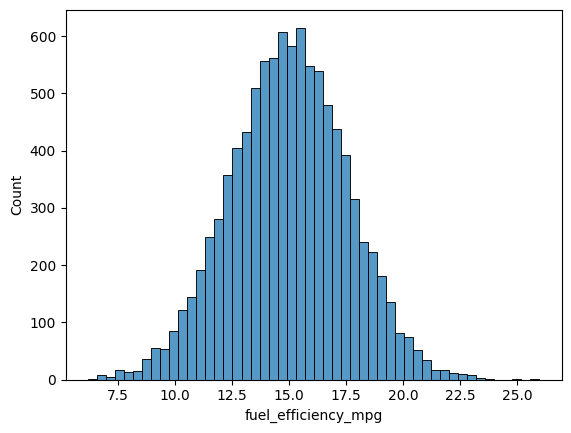

In [7]:
sns.histplot(cfe_df[target_col], bins=50)

#### Define functions

In [8]:
# Split the dataset
def split_train_val_test(df, val_ratio=.2, test_ratio=.2, r_seed=1, verbose=False):
    """Use the train_test_split function from sklearn to split input dataframe
    into randomly shuffled train, validation, and test datasets with the
    validation dataset containing val_ratio of the input data and the test
    dataset containing test_ratio of the input data.
    """
    n = len(df)
    # Generate test dataset
    full_train_df, test_df = train_test_split(df, test_size=test_ratio, random_state=r_seed)
    test_df = test_df.reset_index(drop=True)
    # Generate train, validation, and test splits
    val_ft_ratio = val_ratio / (1 - test_ratio)
    train_df, val_df = train_test_split(full_train_df, test_size=val_ft_ratio, random_state=r_seed)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    if verbose:
        print(f"All rows in the original dataframe are contained within the training, validation, or test datasets: {len(train_df) + len(val_df) + len(test_df) == len(df)}")
    return train_df, val_df, test_df

def split_full_train_test(df, test_ratio=.2, r_seed=1, verbose=False):
    """Use the train_test_split function from sklearn to split input dataframe
    into randomly shuffled train, validation, and test datasets with the
    validation dataset containing val_ratio of the input data and the test
    dataset containing test_ratio of the input data.
    """
    n = len(df)
    # Generate test dataset
    full_train_df, test_df = train_test_split(df, test_size=test_ratio, random_state=r_seed)
    test_df = test_df.reset_index(drop=True)
    full_train_df = full_train_df.reset_index(drop=True)
    if verbose:
        print(f"All rows in the original dataframe are contained within the training, validation, or test datasets: {len(full_train_df) + len(test_df) == len(df)}")
    return full_train_df, test_df
    
# Prepare X and y
def prepare_X_y(df_list, target_col, scale_num_cols=False, verbose=False, labels=[" training "]):
    """Create target vector, y, and feature matrix, X, from input list of
    dataframes, df_list. Use one-hot encoding to transform categorical variables.
    A training dataframe must be input to train the encoders and it must
    correspond to a label in the input list, labels, that contains the word
    "train". Numerical columns are scaled using the StandardScaler if the
    parameter, scale_num_cols, contains a list of numeric columns. The
    validation and test dataframes are optional and they will be encoded based
    on a fit to the training dataframe.
    """
    X_list = []
    y_list = []
    for ind, df in enumerate(df_list):
        # print(ind, df)
        df = df.copy()
        y_tmp = df[target_col].values
        tmp_dicts = df.drop(columns=target_col).to_dict(orient="records")
        if "training" in labels[ind]:
            dv = DictVectorizer(sparse=True)
            X_tmp = dv.fit_transform(tmp_dicts)
            X_names = dv.get_feature_names_out().astype(str)
            if scale_num_cols:
                X_num_cols = np.isin(X_names, scale_num_cols)
                scaler = StandardScaler()
                X_tmp[:, X_num_cols] = scaler.fit_transform(X_tmp[:, X_num_cols])
        else:
            X_tmp = dv.transform(tmp_dicts)
            if scale_num_cols:
                X_tmp[:, X_num_cols] = scaler.fit_transform(X_tmp[:, X_num_cols])
        if verbose:
            if len(labels) != len(df_list):
                labels = labels * len(df_list)
            print(f"All {len(df)} rows in the{labels[ind]}dataframe are contained within X and y: {len(X_tmp) == len(y_tmp) == len(df)}\n")
        X_list.append(X_tmp)
        y_list.append(y_tmp)
    return X_list, y_list, X_names

def model_validation_rmse(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

def evaluate_rfr(X_train, y_train, X_val, y_val, **rfr_params):
    rfr = RandomForestRegressor(**rfr_params)
    rmse = model_validation_rmse(rfr, X_train, y_train, X_val, y_val)
    return rmse

### Split the data into train, validation, and test datasets
1. Split the data in train/val/test sets with 60%/20%/20% distribution
2. Use Scikit-Learn for splitting (the train_test_split function) and set the seed to 1

Make sure that the target value y is not in your dataframe.

In [9]:
train_df, val_df, test_df = split_train_val_test(cfe_df, verbose=True)

All rows in the original dataframe are contained within the training, validation, or test datasets: True


### Q1. Decision tree feature importance
Train a decision tree regressor to predict the `fuel_efficiency_mpg` variable with `max_depth=1`.

Which feature is used for splitting the data?

In [10]:
(X_train, X_val), (y_train, y_val), X_names = prepare_X_y([train_df, val_df], target_col=target_col, verbose=False, labels=[" training ", " validation "])

In [11]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=X_names))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [12]:
print(f"The feature used for spliiting is {BOLD}{X_names[dt.feature_importances_==1][0]}")

The feature used for spliiting is vehicle_weight


### Q2. Random forest RMSE
Train a random forest regressor with these parameters:
1. `n_estimators=10`
2. `random_state=1`
3. `n_jobs=-1` (optional - to make training faster)

What's the RMSE of this model on the validation data?

In [13]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
y_pred = rfr.predict(X_val)
val_rmse = root_mean_squared_error(y_val, y_pred)

In [15]:
print(f"The RMSE on the validation dataset = {BOLD}{round(val_rmse, 3)}")

The RMSE on the validation dataset = 0.46


### Q3. Best `n_estimators` parameter

Experiment with the `n_estimators` parameter:
1. Try different values of this parameter from 10 to 200 with step 10.
2. Set random_state to 1.
3. Evaluate the model on the validation dataset.
4. Consider 3 decimal places for calculating the answer
5. If it doesn't stop improving, use the latest iteration number in your answer

After which value of `n_estimators` does RMSE stop improving?

In [16]:
n_est_vals = range(10, 210, 10)
rfr_params = {'random_state': 1, 'n_jobs': -1}
ne_rmse = {}
for ne in n_est_vals:
    rfr_params['n_estimators'] = ne
    rmse_val = evaluate_rfr(X_train, y_train, X_val, y_val, **rfr_params)
    print(f"n_estimators: RMSE = {ne}: {rmse_val}")
    ne_rmse[ne] = [round(rmse_val, 3)]
ne_rmse_dict = pd.DataFrame.from_dict(ne_rmse, orient='index', columns=['RMSE'])

n_estimators: RMSE = 10: 0.4595777223092726
n_estimators: RMSE = 20: 0.4535906725124706
n_estimators: RMSE = 30: 0.45168672575457125
n_estimators: RMSE = 40: 0.4487208301736996
n_estimators: RMSE = 50: 0.4466568972416094
n_estimators: RMSE = 60: 0.445459702608112
n_estimators: RMSE = 70: 0.4451263244986996
n_estimators: RMSE = 80: 0.44498431197772836
n_estimators: RMSE = 90: 0.44486149063998753
n_estimators: RMSE = 100: 0.44465186808680424
n_estimators: RMSE = 110: 0.44357876439860233
n_estimators: RMSE = 120: 0.44391186812338174
n_estimators: RMSE = 130: 0.44370259039668697
n_estimators: RMSE = 140: 0.4433549955101688
n_estimators: RMSE = 150: 0.44289761494219454
n_estimators: RMSE = 160: 0.4427612219659299
n_estimators: RMSE = 170: 0.44280146504730905
n_estimators: RMSE = 180: 0.44236195357041347
n_estimators: RMSE = 190: 0.4424939711220692
n_estimators: RMSE = 200: 0.4424785084688597


In [17]:
print(f"The `n_estimators` value with the lowest RMSE = {BOLD}{ne_rmse_dict.idxmin().values[0]}")

The `n_estimators` value with the lowest RMSE = 180


### Q4. Best `max_depth` parameter
Select the best `max_depth`:
1. Try different values of max_depth: [10, 15, 20, 25]
2. For each of these values,
   1. Try different values of n_estimators from 10 till 200 (with step 10)
   2. Calculate the mean RMSE
3. Fix the random seed: `random_state`=1

What's the best max_depth, using the mean RMSE?

In [18]:
max_depth_vals = [10, 15, 20, 25]
n_est_vals = range(10, 210, 10)
rfr_params = {'random_state': 1, 'n_jobs': -1}
md_rmse = {}
for md in max_depth_vals:
    rfr_params['max_depth'] = md
    ne_rmse = []
    for ne in n_est_vals:
        rfr_params['n_estimators'] = ne
        rmse_val = evaluate_rfr(X_train, y_train, X_val, y_val, **rfr_params)
        print(f"(max_depth, n_estimators): RMSE = ({md}, {ne}): {rmse_val}")
        ne_rmse.append(rmse_val)
    md_rmse[md] = [np.mean(ne_rmse)]
md_rmse_dict = pd.DataFrame.from_dict(md_rmse, orient='index', columns=['RMSE'])

(max_depth, n_estimators): RMSE = (10, 10): 0.45024865970585237
(max_depth, n_estimators): RMSE = (10, 20): 0.44685703362920204
(max_depth, n_estimators): RMSE = (10, 30): 0.44547396459413735
(max_depth, n_estimators): RMSE = (10, 40): 0.44306731129625837
(max_depth, n_estimators): RMSE = (10, 50): 0.44195668621793566
(max_depth, n_estimators): RMSE = (10, 60): 0.4416730330613032
(max_depth, n_estimators): RMSE = (10, 70): 0.4412975503694071
(max_depth, n_estimators): RMSE = (10, 80): 0.44143523500728943
(max_depth, n_estimators): RMSE = (10, 90): 0.4415215165581005
(max_depth, n_estimators): RMSE = (10, 100): 0.44121699790710184
(max_depth, n_estimators): RMSE = (10, 110): 0.44052622724782486
(max_depth, n_estimators): RMSE = (10, 120): 0.4407083659646052
(max_depth, n_estimators): RMSE = (10, 130): 0.440629500094825
(max_depth, n_estimators): RMSE = (10, 140): 0.44033941277349004
(max_depth, n_estimators): RMSE = (10, 150): 0.43994270355172643
(max_depth, n_estimators): RMSE = (10, 1

In [19]:
print(f"The `max_depth` value with the lowest Mean RMSE: {BOLD}{md_rmse_dict.idxmin().values[0]}")

The `max_depth` value with the lowest Mean RMSE: 10


### Q5. Feature importance
Extract feature importance information from the tree-based model. At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field. For this homework question, we'll find the most important feature:
1. Train the model with these parameters:
  1. `n_estimators`=10, `max_depth`=20, `random_state`=1, `n_jobs`=-1 (optional)
  2. Get the feature importance information from this model

What's the most important feature (among these 4)?

In [20]:
rfr_params = {'n_estimators': 10, 'max_depth': 20, 'random_state': 1, 'n_jobs': -1}
rfr = RandomForestRegressor(**rfr_params)
rfr.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
print(f" {BOLD}{str(X_names[rfr.feature_importances_.argmax()])}")

 vehicle_weight


### Q6. XGBoost `eta` parameter with best RMSE
Train an XGBoost model and tune the `eta` parameter:
1. Install XGBoost
2. Create DMatrix for train and validation
3. Create a watchlist
4. Train a model with these parameters for 100 rounds:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

5. Change `eta` from 0.3 to 0.1 and retrain the model.

Which eta leads to the best RMSE score on the validation dataset?

In [27]:
xgb_params = {
    'eta': 0.3,\
    'max_depth': 6,\
    'min_child_weight': 1,\
    'objective': 'reg:squarederror',\
    'nthread': 8,\
    'seed': 1,\
    'verbosity': 1,\
}
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [28]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X_names))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(X_names))

In [39]:
evals_result = {}
model = xgb.train(xgb_params, dtrain, evals_result=evals_result, verbose_eval=False, evals=watchlist, num_boost_round=100)
df_eta_3 = pd.DataFrame([evals_result['train']['rmse'], evals_result['val']['rmse']]).T
df_eta_3.columns = ['train', 'val']
eta_3_min_rmse = df_eta_3['val'].min()
print(f"The minimum RMSE for eta=0.3 = {round(eta_3_min_rmse, 4)}")

The minimum RMSE for eta=0.3 = 0.4335


In [41]:
xgb_params['eta'] = 0.1
evals_result = {}
model = xgb.train(xgb_params, dtrain, evals_result=evals_result, verbose_eval=False, evals=watchlist, num_boost_round=100)
df_eta_1 = pd.DataFrame([evals_result['train']['rmse'], evals_result['val']['rmse']]).T
df_eta_1.columns = ['train', 'val']
eta_1_min_rmse = df_eta_1['val'].min()
print(f"The minimum RMSE for eta=0.1 = {round(eta_1_min_rmse, 4)}")

The minimum RMSE for eta=0.1 = 0.4243


In [42]:
print(f"The eta value that produces the best RMSE = {BOLD}{"0.1" if eta_1_min_rmse < eta_3_min_rmse else "0.3"}")

The eta value that produces the best RMSE = 0.1


### Extra Credit

array(['acceleration', 'drivetrain=All-wheel drive',
       'drivetrain=Front-wheel drive', 'engine_displacement',
       'fuel_type=Diesel', 'fuel_type=Gasoline', 'horsepower',
       'model_year', 'num_cylinders', 'num_doors', 'origin=Asia',
       'origin=Europe', 'origin=USA', 'vehicle_weight'], dtype='<U28')